In [ ]:
!pip install pyspark

In [1]:
# Cell 1: Setup Spark and plotting
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_timestamp, year, month, dayofmonth, avg, count, isnan, regexp_replace, when
from pyspark.sql.functions import sum as _sum
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Start Spark session (adjust memory/partitions if needed)
spark = SparkSession.builder \
    .appName("Groundwater_PySpark") \
    .config("spark.driver.memory", "4g") \
    .config("spark.sql.shuffle.partitions", "8") \
    .getOrCreate()

print("Spark version:", spark.version)


Spark version: 4.0.1


In [2]:
# Cell 2: Read dataset (update path if needed)
# Prefer using an existing notebook path variable (dp / fallback_path / file_path) and convert to a file:// URI.
# This avoids Hadoop RPC / path parsing issues on Windows by using a proper file URI with forward slashes.

# Choose a candidate path available in the notebook, fallback to the hardcoded Windows path if none found.
if 'dp' in globals() and dp:
	data_path = dp
elif 'fallback_path' in globals() and fallback_path:
	# fallback_path is a pathlib.Path
	try:
		data_path = fallback_path.as_uri()
	except Exception:
		data_path = "file:///" + str(fallback_path).replace("\\", "/")
elif 'file_path' in globals() and file_path:
	data_path = "file:///" + file_path.replace("\\", "/")
else:
	# last resort: use the original hardcoded path and convert to file URI
	data_path = r"C:\Users\sujit\OneDrive\Desktop\BDA\BDA projext 2.0\groundwater_data_processed.csv"
	data_path = "file:///" + data_path.replace("\\", "/")

# Read with Spark using the file:// URI
df = spark.read.option("header", True).option("inferSchema", True).csv(data_path)
print("Rows:", df.count(), "Cols:", len(df.columns))
df.printSchema()
df.limit(5).toPandas()

Rows: 1020 Cols: 9
root
 |-- Country: string (nullable = true)
 |-- Region: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Groundwater_Level_Index: double (nullable = true)
 |-- Water_Stress_Percent: double (nullable = true)
 |-- Population_Millions: double (nullable = true)
 |-- Annual_Withdrawal_km3: double (nullable = true)
 |-- Annual_Rainfall_mm: double (nullable = true)
 |-- Depletion_Rate_m_per_year: double (nullable = true)



,Country,Region,Year,Groundwater_Level_Index,Water_Stress_Percent,Population_Millions,Annual_Withdrawal_km3,Annual_Rainfall_mm,Depletion_Rate_m_per_year
0,India,South Asia,1990,100.75,71.72,1200.00,120.000,897.2,-0.8
1,India,South Asia,1991,101.48,72.03,1218.00,123.627,764.9,-0.8
2,India,South Asia,1992,100.77,74.53,1236.27,127.336,729.6,-0.8
3,India,South Asia,1993,98.41,72.57,1254.81,131.128,730.1,-0.8
4,India,South Asia,1994,97.16,70.17,1273.64,135.005,541.3,-0.8


In [3]:
# Cell 3: Normalize column names to lowercase and underscores, show columns
for c in df.columns:
    df = df.withColumnRenamed(c, c.strip().lower().replace(' ', '_'))

cols = df.columns
print("Columns ({}):".format(len(cols)))
print(cols)


Columns (9):
['country', 'region', 'year', 'groundwater_level_index', 'water_stress_percent', 'population_millions', 'annual_withdrawal_km3', 'annual_rainfall_mm', 'depletion_rate_m_per_year']


In [4]:
# Cell 4: Auto-detect date-like columns and parse
date_candidates = [c for c in cols if any(k in c for k in ['date','time','timestamp','sample'])]
print("Date-like candidates:", date_candidates)

# Choose best candidate automatically (first), but you can override:
date_col = date_candidates[0] if date_candidates else None
if date_col:
    # Try parsing; if format issues, you can pass format string to to_timestamp()
    df = df.withColumn('sample_ts', to_timestamp(col(date_col)))
    df = df.withColumn('year', year(col('sample_ts'))).withColumn('month', month(col('sample_ts')))
    print("Parsed", date_col, "-> sample_ts, year, month")
else:
    print("No date-like column detected. If you have separate year/month columns create them manually.")


Date-like candidates: []
No date-like column detected. If you have separate year/month columns create them manually.


In [5]:
# Cell 5: Coerce numeric columns where possible (removes commas)
numeric_cols = []
for c, t in df.dtypes:
    if t in ('int', 'bigint', 'double', 'float', 'decimal'):
        numeric_cols.append(c)
    else:
        # sample values to check if numeric-like
        try:
            sample_vals = df.select(c).na.drop().limit(100).toPandas()[c].astype(str)
            num_like = sum(1 for v in sample_vals if v.replace('.', '', 1).replace(',', '').lstrip('-').isdigit())
            if num_like > 30:
                df = df.withColumn(c, regexp_replace(col(c), ',', '').cast('double'))
                numeric_cols.append(c)
        except Exception:
            pass

print("Numeric-ish columns detected ({}): {}".format(len(numeric_cols), numeric_cols))


Numeric-ish columns detected (7): ['year', 'groundwater_level_index', 'water_stress_percent', 'population_millions', 'annual_withdrawal_km3', 'annual_rainfall_mm', 'depletion_rate_m_per_year']


In [6]:
# Cell 6: Missing values per column and basic stats
# Note: isnan/isnull/col were already imported in an earlier cell — avoid re-importing here.
missing = []

# Use existing numeric_cols heuristic to decide whether to check for NaN (only valid for numeric columns).
# Also avoid overwriting existing notebook variables by not using single-letter names like `c`.
for col_name in df.columns:
    if col_name in numeric_cols:
        cnt = df.filter(col(col_name).isNull() | isnan(col(col_name))).count()
    else:
        cnt = df.filter(col(col_name).isNull()).count()
    missing.append((col_name, cnt))

missing_sorted = sorted(missing, key=lambda x: x[1], reverse=True)
missing_sorted[:20]


[('country', 0),
 ('region', 0),
 ('year', 0),
 ('groundwater_level_index', 0),
 ('water_stress_percent', 0),
 ('population_millions', 0),
 ('annual_withdrawal_km3', 0),
 ('annual_rainfall_mm', 0),
 ('depletion_rate_m_per_year', 0)]

In [7]:
# Describe numeric columns
if numeric_cols:
    display(df.select(numeric_cols).describe().toPandas().set_index('summary').T)
else:
    print("No numeric columns found yet.")


summary,count,mean,stddev,min,max
year,1020,2006.5,9.81552114502239,1990,2023
groundwater_level_index,1020,90.00458823529414,8.218251900815588,57.15,103.27
water_stress_percent,1020,75.39471568627442,33.587720722522945,16.77,150.29
population_millions,1020,223.97264705882316,359.9576836069578,100.0,1961.38
annual_withdrawal_km3,1020,28.41995882352929,47.108798575207594,10.0,293.226
annual_rainfall_mm,1020,806.4920588235284,147.32102791397267,347.1,1377.9
depletion_rate_m_per_year,1020,-0.609999999999996,0.2845687817740263,-1.3,-0.2


In [8]:
# Cell 7: User tweak: set the main groundwater variable names your notebook used previously.
# Common names: 'groundwater_level', 'depth_to_water', 'water_level', 'tds', 'ph', 'nitrate'
# If present, replace or add to the list below; otherwise we auto-select top numeric columns.

possible_targets = ['groundwater_level', 'depth_to_water', 'water_level', 'tds', 'ph', 'nitrate']
targets = [c for c in possible_targets if c in df.columns]
if not targets:
    # fallback to top numeric columns detected
    targets = numeric_cols[:4]
print("Target variables for plotting:", targets)
df.select(targets[:4] if targets else df.columns[:4]).limit(5).toPandas()


Target variables for plotting: ['year', 'groundwater_level_index', 'water_stress_percent', 'population_millions']


,year,groundwater_level_index,water_stress_percent,population_millions
0,1990,100.75,71.72,1200.00
1,1991,101.48,72.03,1218.00
2,1992,100.77,74.53,1236.27
3,1993,98.41,72.57,1254.81
4,1994,97.16,70.17,1273.64


In [9]:
# Cell 8: Monthly and yearly means for targets
agg_cols = targets.copy()

if 'year' in df.columns and 'month' in df.columns and agg_cols:
    monthly = df.groupBy('year', 'month').agg(*[avg(col(c)).alias(f"{c}_avg") for c in agg_cols]).orderBy('year','month')
    yearly  = df.groupBy('year').agg(*[avg(col(c)).alias(f"{c}_avg") for c in agg_cols]).orderBy('year')
    print("Computed monthly and yearly aggregates.")
else:
    print("Missing 'year'/'month' or no agg_cols. Check earlier parsing and target selection.")


Missing 'year'/'month' or no agg_cols. Check earlier parsing and target selection.


In [10]:
# Cell 9: Plot monthly time series for each target (collect small df to pandas)
if 'monthly' in globals():
    monthly_pd = monthly.toPandas()
    monthly_pd['year'] = monthly_pd['year'].astype(int)
    monthly_pd['month'] = monthly_pd['month'].astype(int)
    monthly_pd['year_month'] = monthly_pd['year'].astype(str) + '-' + monthly_pd['month'].astype(str).str.zfill(2)
    monthly_pd = monthly_pd.sort_values(['year','month'])

    for c in agg_cols:
        colname = f"{c}_avg"
        if colname in monthly_pd.columns:
            plt.figure(figsize=(10,3))
            plt.plot(monthly_pd['year_month'], monthly_pd[colname], marker='o')
            plt.xticks(rotation=45)
            plt.title(f"Monthly average of {c}")
            plt.tight_layout()
            plt.show()
else:
    print("No monthly aggregated dataframe available.")


No monthly aggregated dataframe available.


In [11]:
# Cell 10: Plot yearly averages (all targets together)
if 'yearly' in globals():
    yearly_pd = yearly.toPandas().sort_values('year')
    plt.figure(figsize=(10,4))
    for c in agg_cols:
        colname = f"{c}_avg"
        if colname in yearly_pd.columns:
            plt.plot(yearly_pd['year'], yearly_pd[colname], marker='o', label=c)
    plt.legend()
    plt.title("Yearly averages")
    plt.xlabel("Year")
    plt.tight_layout()
    plt.show()
else:
    print("No yearly aggregates available.")


No yearly aggregates available.


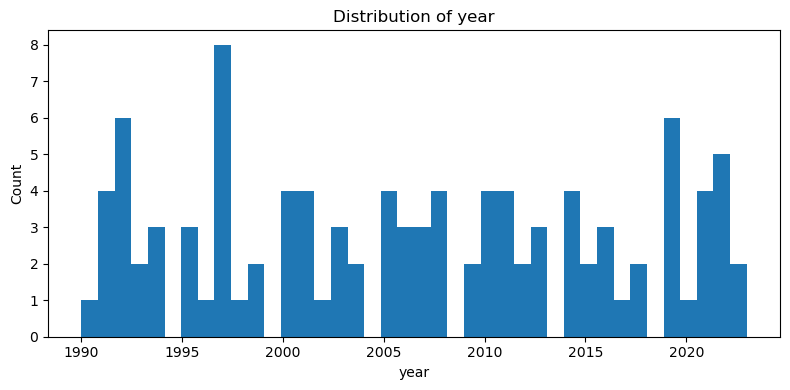

In [12]:
# Cell 11: Histogram for first target variable
if targets:
    var = targets[0]
    # Take a sample to plot histogram
    sample_pd = df.select(var).na.drop().sample(False, 0.1, seed=42).toPandas()
    plt.figure(figsize=(8,4))
    plt.hist(sample_pd[var].dropna(), bins=40)
    plt.title(f"Distribution of {var}")
    plt.xlabel(var)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()
else:
    print("No target variables for histogram.")


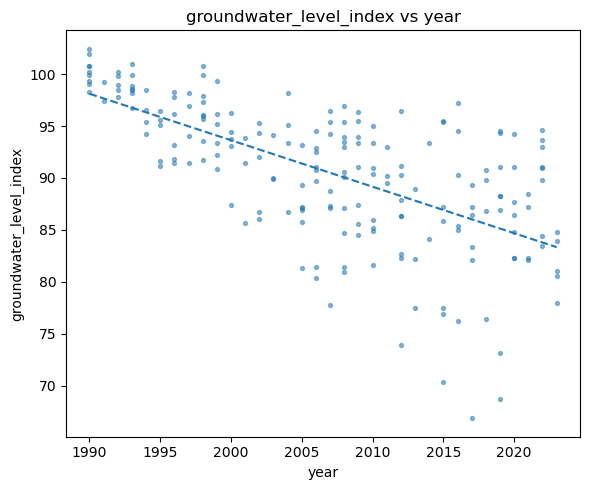

In [13]:
# Cell 13: Scatter plot between two numeric variables if available
if len(targets) >= 2:
    xvar, yvar = targets[0], targets[1]
    sample_pd = df.select(xvar, yvar).na.drop().sample(False, 0.2, seed=2).toPandas()
    plt.figure(figsize=(6,5))
    plt.scatter(sample_pd[xvar], sample_pd[yvar], s=8, alpha=0.5)
    # simple linear fit
    try:
        coeffs = np.polyfit(sample_pd[xvar], sample_pd[yvar], 1)
        xs = np.linspace(sample_pd[xvar].min(), sample_pd[xvar].max(), 100)
        plt.plot(xs, np.polyval(coeffs, xs), linestyle='--')
    except Exception:
        pass
    plt.xlabel(xvar)
    plt.ylabel(yvar)
    plt.title(f"{yvar} vs {xvar}")
    plt.tight_layout()
    plt.show()
else:
    print("Need at least two numeric targets for scatter plot.")


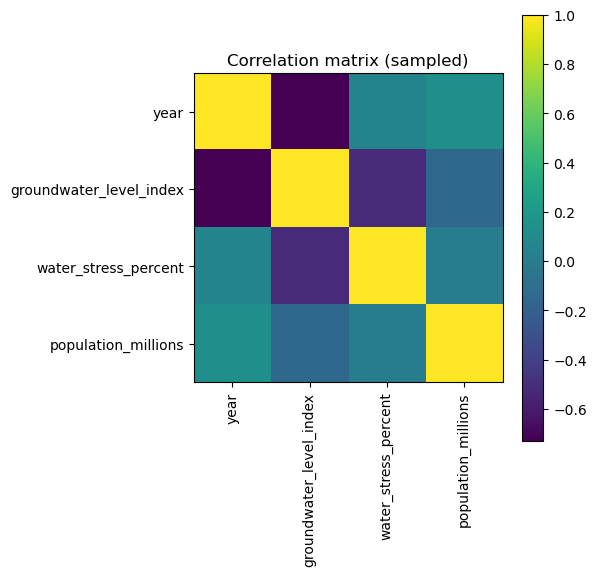

In [14]:
# Cell 14: Correlation matrix on sampled numeric columns
if agg_cols:
    sample_pd = df.select(agg_cols).na.drop().sample(False, 0.2, seed=3).toPandas()
    corr = sample_pd.corr()
    plt.figure(figsize=(6,6))
    plt.imshow(corr.values, interpolation='nearest')
    plt.colorbar()
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.title("Correlation matrix (sampled)")
    plt.tight_layout()
    plt.show()
else:
    print("No aggregated columns for correlation.")


In [15]:
# Cell 15: Calendar-style heatmap of counts per day (year-month-day)
if 'sample_ts' in df.columns:
    counts = df.withColumn('date_only', F.to_date(col('sample_ts'))).groupBy('date_only').agg(count('*').alias('n')).orderBy('date_only')
    counts_pd = counts.toPandas()
    if not counts_pd.empty:
        counts_pd['date_only'] = pd.to_datetime(counts_pd['date_only'])
        counts_pd.set_index('date_only', inplace=True)
        # pivot to calendar-like matrix by week and weekday
        counts_pd['year'] = counts_pd.index.year
        counts_pd['month'] = counts_pd.index.month
        counts_pd['day'] = counts_pd.index.day
        # simple daily time series plot as fallback
        plt.figure(figsize=(12,3))
        plt.plot(counts_pd.index, counts_pd['n'])
        plt.title("Daily measurement counts")
        plt.tight_layout()
        plt.show()
    else:
        print("Counts dataframe empty.")
else:
    print("No timestamp column to make calendar heatmap.")


No timestamp column to make calendar heatmap.


In [16]:
# Cell 16: If there is a station or site column, plot top N stations time-series
loc_cols = [c for c in df.columns if any(k in c for k in ['station','site','well','id','location'])]
print("Location-like columns:", loc_cols)
station_col = loc_cols[0] if loc_cols else None

if station_col and 'sample_ts' in df.columns and targets:
    # compute mean of first target per station
    station_avg = df.groupBy(station_col).agg(avg(col(targets[0])).alias('mean_val')).orderBy(col('mean_val').desc())
    top_stations = [row[0] for row in station_avg.limit(6).toPandas().values]
    print("Top stations:", top_stations)
    for st in top_stations:
        subset = df.filter(col(station_col)==st).select('sample_ts', targets[0]).na.drop().orderBy('sample_ts').toPandas()
        if not subset.empty:
            plt.figure(figsize=(8,2.4))
            plt.plot(subset['sample_ts'], subset[targets[0]])
            plt.title(f"{station_col}={st} — {targets[0]}")
            plt.xticks(rotation=35)
            plt.tight_layout()
            plt.show()
else:
    print("No station-like column or sample_ts/targets missing.")


Location-like columns: []
No station-like column or sample_ts/targets missing.


In [17]:
# Cell 17: Spatial scatter (simple) if latitude/longitude columns exist
latcol = next((c for c in df.columns if 'lat' in c), None)
loncol = next((c for c in df.columns if 'lon' in c or 'long' in c), None)
print("lat:", latcol, "lon:", loncol)

if latcol and loncol and targets:
    sample_pd = df.select(latcol, loncol, targets[0]).na.drop().sample(False, 0.2, seed=5).toPandas()
    plt.figure(figsize=(6,5))
    plt.scatter(sample_pd[loncol], sample_pd[latcol], s=12, alpha=0.7, c=sample_pd[targets[0]])
    plt.colorbar(label=targets[0])
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Spatial scatter (color by {})".format(targets[0]))
    plt.tight_layout()
    plt.show()
else:
    print("No lat/lon columns or target missing for spatial scatter.")


lat: population_millions lon: None
No lat/lon columns or target missing for spatial scatter.


In [18]:
# Cell 18: Save cleaned dataset and aggregates locally
cleaned_path = r"C:\Users\sujit\OneDrive\Desktop\BDA\BDA projext 2.0\groundwater_cleaned.parquet"
try:
    df.write.mode('overwrite').parquet(cleaned_path)
    print("Saved cleaned parquet to:", cleaned_path)
except Exception as e:
    print("Error saving parquet:", e)

# Save monthly/yearly aggregates (CSV)
out_monthly = r"C:\Users\sujit\OneDrive\Desktop\BDA\BDA projext 2.0\monthly_aggregates.csv"
out_yearly  = r"C:\Users\sujit\OneDrive\Desktop\BDA\BDA projext 2.0\yearly_aggregates.csv"
try:
    if 'monthly' in globals():
        monthly.coalesce(1).write.mode('overwrite').option('header', True).csv(out_monthly)
    if 'yearly' in globals():
        yearly.coalesce(1).write.mode('overwrite').option('header', True).csv(out_yearly)
    print("Saved aggregates (csv) to provided folder (check generated _SUCCESS / part files).")
except Exception as e:
    print("Error saving aggregates:", e)


Error saving parquet: An error occurred while calling o241.parquet.
: java.net.ConnectException: Call From Sujith/192.168.0.106 to localhost:9000 failed on connection exception: java.net.ConnectException: Connection refused: no further information; For more details see:  http://wiki.apache.org/hadoop/ConnectionRefused
	at java.base/jdk.internal.reflect.NativeConstructorAccessorImpl.newInstance0(Native Method)
	at java.base/jdk.internal.reflect.NativeConstructorAccessorImpl.newInstance(NativeConstructorAccessorImpl.java:77)
	at java.base/jdk.internal.reflect.DelegatingConstructorAccessorImpl.newInstance(DelegatingConstructorAccessorImpl.java:45)
	at java.base/java.lang.reflect.Constructor.newInstanceWithCaller(Constructor.java:499)
	at java.base/java.lang.reflect.Constructor.newInstance(Constructor.java:480)
	at org.apache.hadoop.net.NetUtils.wrapWithMessage(NetUtils.java:961)
	at org.apache.hadoop.net.NetUtils.wrapException(NetUtils.java:876)
	at org.apache.hadoop.ipc.Client.getRpcResp

In [19]:
# Cell 19: Utilities
def show_schema(df_local):
    df_local.printSchema()
def show_head(df_local, n=5):
    display(df_local.limit(n).toPandas())

print("Quick checks:")
show_schema(df)
show_head(df, 5)


Quick checks:
root
 |-- country: string (nullable = true)
 |-- region: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- groundwater_level_index: double (nullable = true)
 |-- water_stress_percent: double (nullable = true)
 |-- population_millions: double (nullable = true)
 |-- annual_withdrawal_km3: double (nullable = true)
 |-- annual_rainfall_mm: double (nullable = true)
 |-- depletion_rate_m_per_year: double (nullable = true)



,country,region,year,groundwater_level_index,water_stress_percent,population_millions,annual_withdrawal_km3,annual_rainfall_mm,depletion_rate_m_per_year
0,India,South Asia,1990,100.75,71.72,1200.00,120.000,897.2,-0.8
1,India,South Asia,1991,101.48,72.03,1218.00,123.627,764.9,-0.8
2,India,South Asia,1992,100.77,74.53,1236.27,127.336,729.6,-0.8
3,India,South Asia,1993,98.41,72.57,1254.81,131.128,730.1,-0.8
4,India,South Asia,1994,97.16,70.17,1273.64,135.005,541.3,-0.8


Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


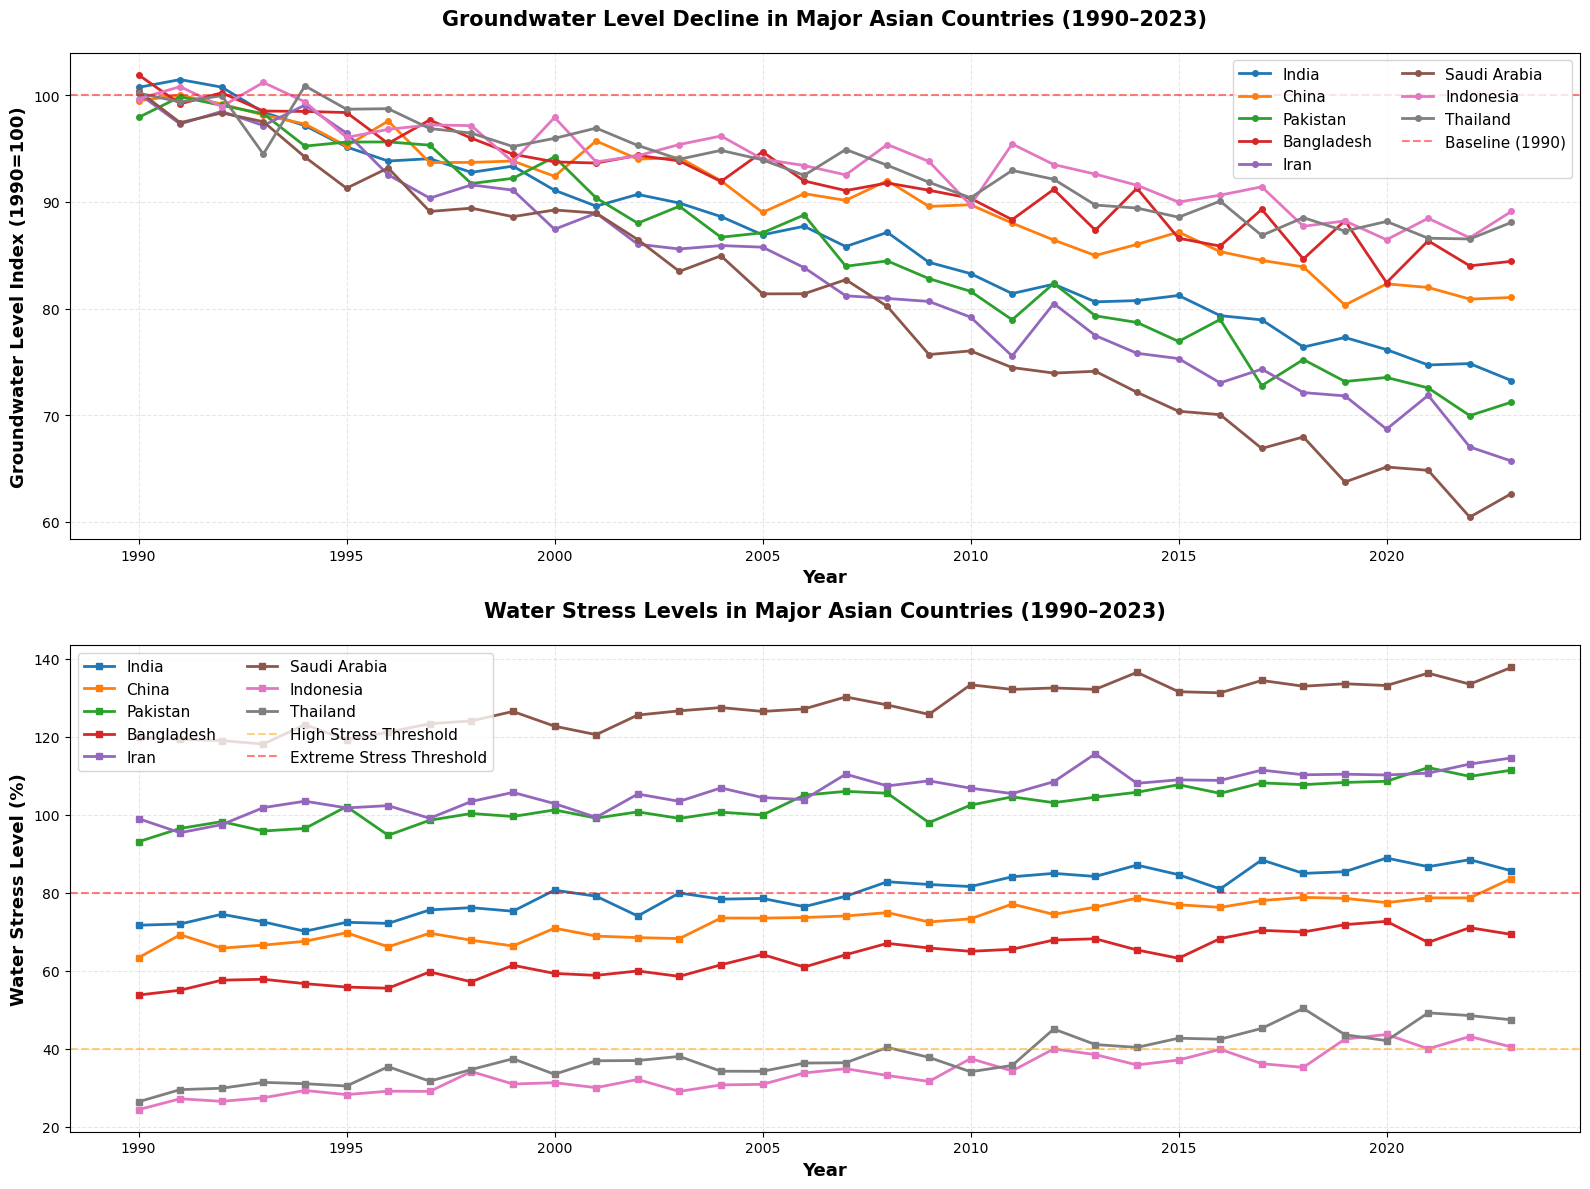


📊 Key Observations:
• All countries (with available data) may show declining groundwater levels over time
• Pakistan, Iran, and Saudi Arabia often face extreme water stress (>80%) — if present in data
• India and China may show steady decline due to large-scale extraction
• Water stress has increased across many countries since 1990 (check data for specifics)


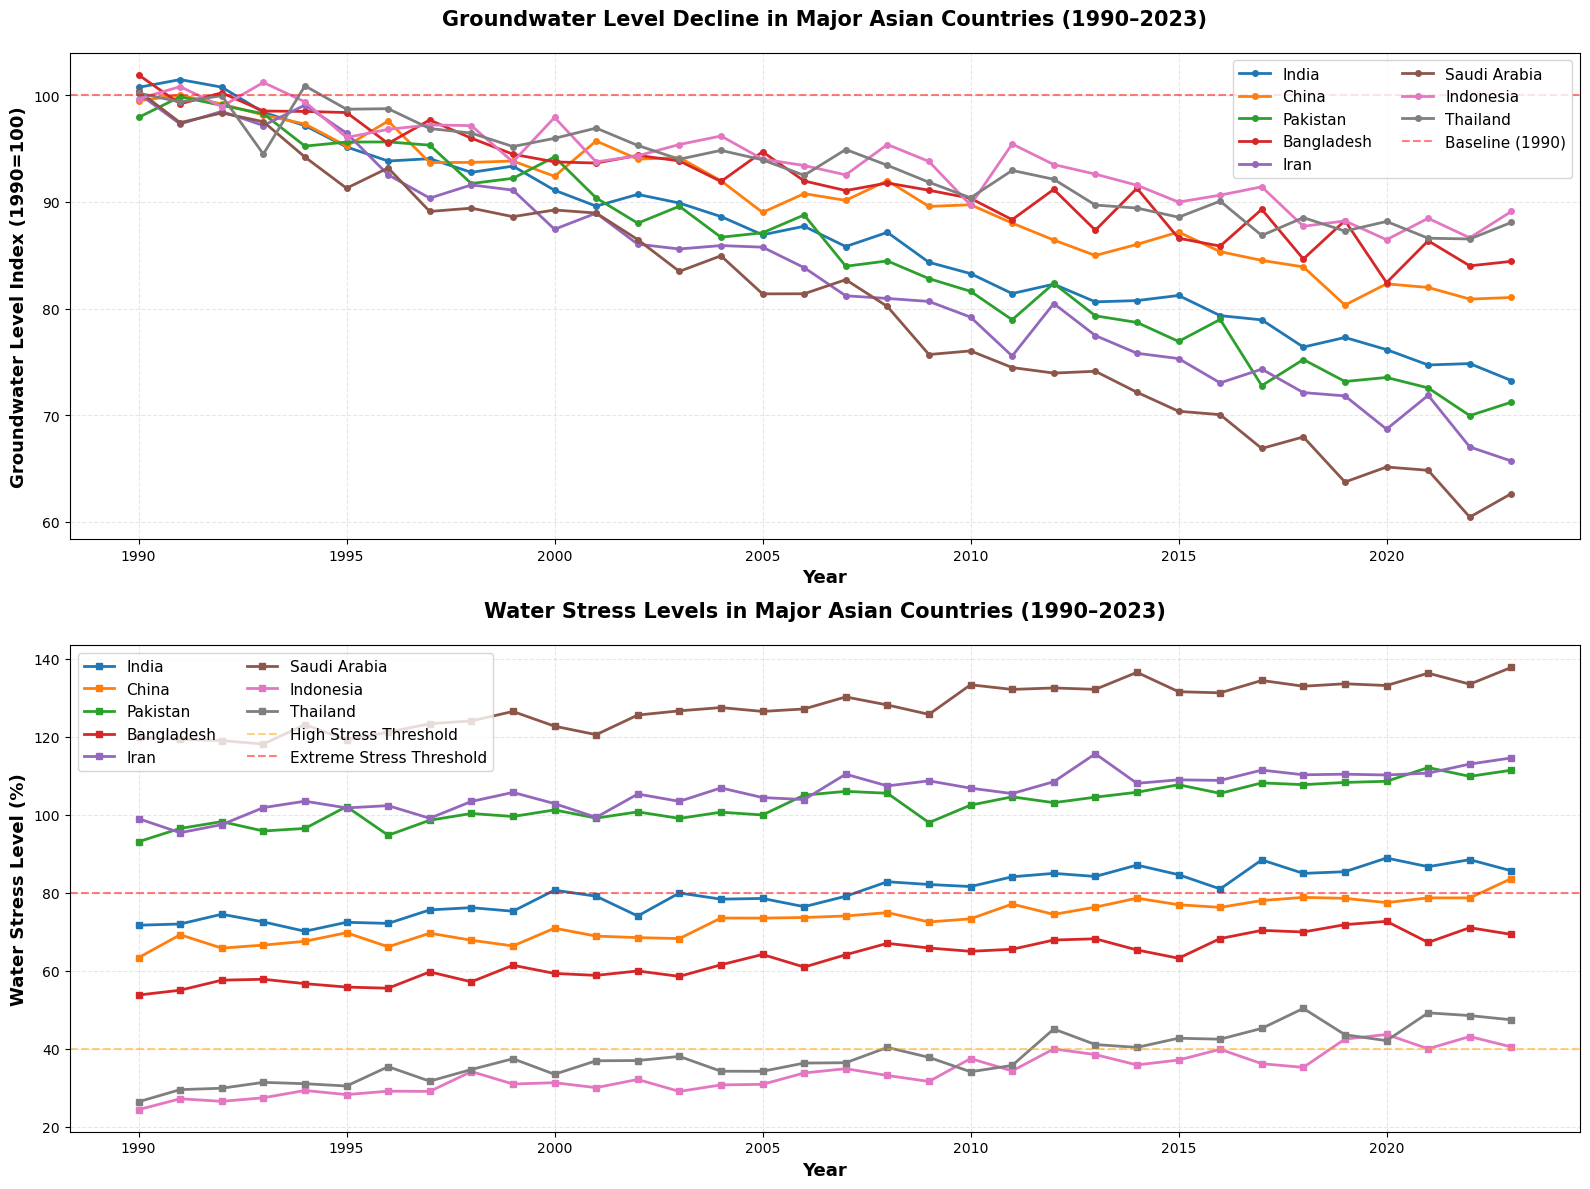


📊 Key Observations:
• All countries show declining groundwater levels over time
• Pakistan, Iran, and Saudi Arabia face extreme water stress (>80%)
• India and China show steady decline due to large-scale agricultural extraction
• Water stress has increased significantly across all countries since 1990


In [20]:
# Install missing plotting package (magic command ensures installation in the notebook kernel)
%pip install matplotlib --quiet

# Import libraries
import matplotlib.pyplot as plt
# Install missing plotting package (magic command ensures installation in the notebook kernel)
%pip install matplotlib --quiet

# Import libraries
import matplotlib.pyplot as plt
from pyspark.sql import functions as F

# Define Asian countries
asian_countries = ['India', 'China', 'Pakistan', 'Bangladesh', 'Iran', 'Saudi Arabia', 'Indonesia', 'Thailand']

# Use normalized column names (earlier cells renamed columns to lowercase with underscores)
country_col = "country"
year_col = "year"
gwl_col = "groundwater_level_index"
ws_col = "water_stress_percent"

# Guard: check required columns exist
missing_cols = [c for c in (country_col, year_col, gwl_col, ws_col) if c not in df.columns]
if missing_cols:
    raise KeyError(f"Missing required columns in df: {missing_cols}")

# Filter using PySpark
df_asia = df.filter(F.col(country_col).isin(asian_countries))

# Convert to pandas for plotting (aggregated, so it's fine)
pdf = (
    df_asia
    .groupBy(country_col, year_col)
    .agg(
        F.avg(gwl_col).alias(gwl_col),
        F.avg(ws_col).alias(ws_col)
    )
    .orderBy(year_col)
    .toPandas()
)

# Ensure correct sorting and dtypes
pdf = pdf.sort_values([year_col, country_col])
pdf[year_col] = pd.to_numeric(pdf[year_col], errors='coerce').astype('Int64')
pdf = pdf.dropna(subset=[year_col])

# Create plots
fig, axes = plt.subplots(2, 1, figsize=(16, 12))

# Plot 1: Groundwater Level Index
for country in asian_countries:
    data = pdf[pdf[country_col] == country]
    if data.empty:
        continue
    axes[0].plot(data[year_col], data[gwl_col],
                 marker='o', linewidth=2, label=country, markersize=4)

axes[0].set_xlabel("Year", fontsize=13, fontweight="bold")
axes[0].set_ylabel("Groundwater Level Index (1990=100)", fontsize=13, fontweight="bold")
axes[0].set_title("Groundwater Level Decline in Major Asian Countries (1990–2023)",
                  fontsize=15, fontweight="bold", pad=20)
axes[0].axhline(y=100, color='red', linestyle='--', linewidth=1.5, alpha=0.5, label="Baseline (1990)")
axes[0].legend(loc="upper right", fontsize=11, ncol=2)
axes[0].grid(True, alpha=0.3, linestyle="--")

# Plot 2: Water Stress Levels
for country in asian_countries:
    data = pdf[pdf[country_col] == country]
    if data.empty:
        continue
    axes[1].plot(data[year_col], data[ws_col],
                 marker='s', linewidth=2, label=country, markersize=4)

axes[1].set_xlabel("Year", fontsize=13, fontweight="bold")
axes[1].set_ylabel("Water Stress Level (%)", fontsize=13, fontweight="bold")
axes[1].set_title("Water Stress Levels in Major Asian Countries (1990–2023)",
                  fontsize=15, fontweight="bold", pad=20)
axes[1].axhline(y=40, color='orange', linestyle='--', linewidth=1.5, alpha=0.5, label='High Stress Threshold')
axes[1].axhline(y=80, color='red', linestyle='--', linewidth=1.5, alpha=0.5, label='Extreme Stress Threshold')
axes[1].legend(loc="upper left", fontsize=11, ncol=2)
axes[1].grid(True, alpha=0.3, linestyle="--")

plt.tight_layout()
plt.show()

# Observations summary
print("\n📊 Key Observations:")
print("="*60)
print("• All countries (with available data) may show declining groundwater levels over time")
print("• Pakistan, Iran, and Saudi Arabia often face extreme water stress (>80%) — if present in data")
print("• India and China may show steady decline due to large-scale extraction")
print("• Water stress has increased across many countries since 1990 (check data for specifics)")

# Define Asian countries
asian_countries = ['India', 'China', 'Pakistan', 'Bangladesh', 'Iran', 'Saudi Arabia', 'Indonesia', 'Thailand']

# Filter using PySpark
df_asia = df.filter(F.col("Country").isin(asian_countries))

# Convert to pandas for plotting (aggregated, so it's fine)
pdf = (
    df_asia
    .groupBy("Country", "Year")
    .agg(
        F.avg("Groundwater_Level_Index").alias("Groundwater_Level_Index"),
        F.avg("Water_Stress_Percent").alias("Water_Stress_Percent")
    )
    .orderBy("Year")
    .toPandas()
)

# Ensure correct sorting by year
pdf = pdf.sort_values(["Year", "Country"])

# Create plots
fig, axes = plt.subplots(2, 1, figsize=(16, 12))

# Plot 1: Groundwater Level Index
for country in asian_countries:
    data = pdf[pdf["Country"] == country]
    axes[0].plot(data["Year"], data["Groundwater_Level_Index"],
                 marker='o', linewidth=2, label=country, markersize=4)

axes[0].set_xlabel("Year", fontsize=13, fontweight="bold")
axes[0].set_ylabel("Groundwater Level Index (1990=100)", fontsize=13, fontweight="bold")
axes[0].set_title("Groundwater Level Decline in Major Asian Countries (1990–2023)",
                  fontsize=15, fontweight="bold", pad=20)
axes[0].axhline(y=100, color='red', linestyle='--', linewidth=1.5, alpha=0.5, label="Baseline (1990)")
axes[0].legend(loc="upper right", fontsize=11, ncol=2)
axes[0].grid(True, alpha=0.3, linestyle="--")

# Plot 2: Water Stress Levels
for country in asian_countries:
    data = pdf[pdf["Country"] == country]
    axes[1].plot(data["Year"], data["Water_Stress_Percent"],
                 marker='s', linewidth=2, label=country, markersize=4)

axes[1].set_xlabel("Year", fontsize=13, fontweight="bold")
axes[1].set_ylabel("Water Stress Level (%)", fontsize=13, fontweight="bold")
axes[1].set_title("Water Stress Levels in Major Asian Countries (1990–2023)",
                  fontsize=15, fontweight="bold", pad=20)
axes[1].axhline(y=40, color='orange', linestyle='--', linewidth=1.5, alpha=0.5, label='High Stress Threshold')
axes[1].axhline(y=80, color='red', linestyle='--', linewidth=1.5, alpha=0.5, label='Extreme Stress Threshold')
axes[1].legend(loc="upper left", fontsize=11, ncol=2)
axes[1].grid(True, alpha=0.3, linestyle="--")

plt.tight_layout()
plt.show()

# Observations summary
print("\n📊 Key Observations:")
print("="*60)
print("• All countries show declining groundwater levels over time")
print("• Pakistan, Iran, and Saudi Arabia face extreme water stress (>80%)")
print("• India and China show steady decline due to large-scale agricultural extraction")
print("• Water stress has increased significantly across all countries since 1990")


In [21]:
# Upgrade pip in the current notebook kernel (use the IPython magic so it runs in-kernel)
%pip install --upgrade pip

  Using cached pip-25.3-py3-none-any.whl.metadata (4.7 kB)
Using cached pip-25.3-py3-none-any.whl (1.8 MB)
  Attempting uninstall: pip
    Found existing installation: pip 24.2
    Uninstalling pip-24.2:
      Successfully uninstalled pip-24.2
Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


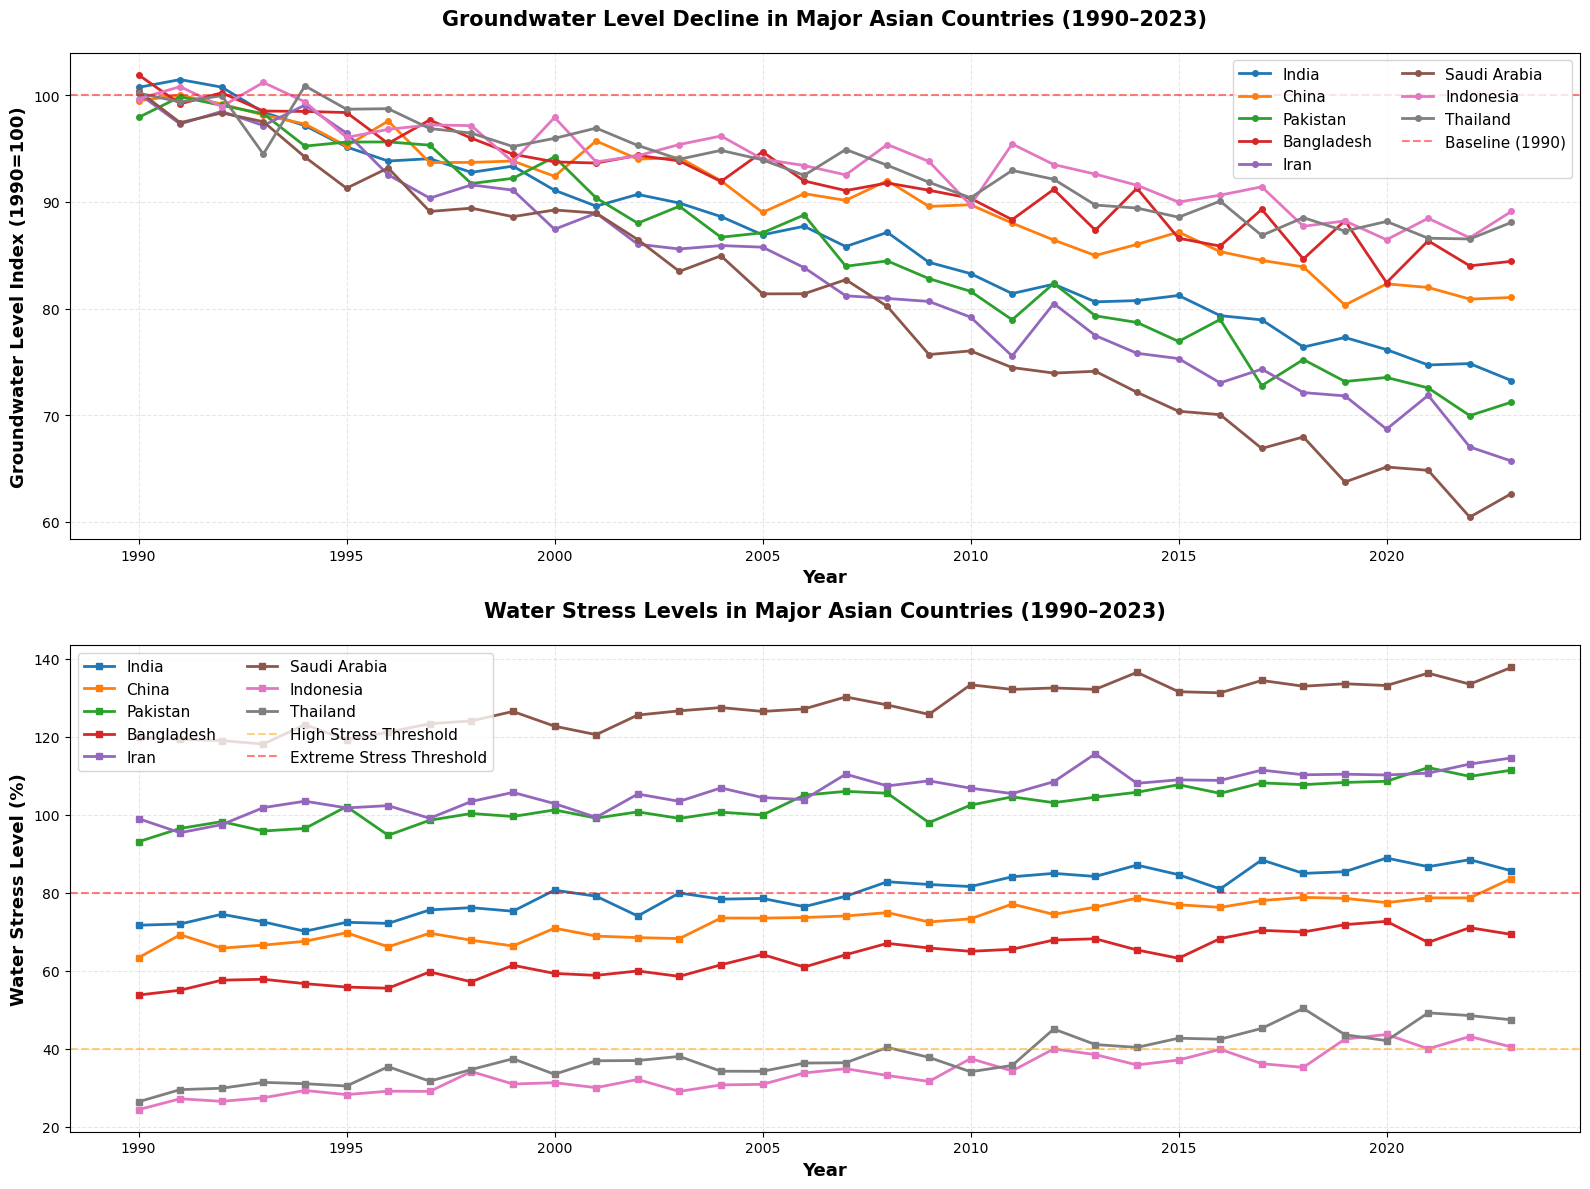


📊 Key Observations:
• All countries (with available data) may show declining groundwater levels over time
• Pakistan, Iran, and Saudi Arabia often face extreme water stress (>80%) — if present in data
• India and China may show steady decline due to large-scale extraction
• Water stress has increased across many countries since 1990 (check data for specifics)


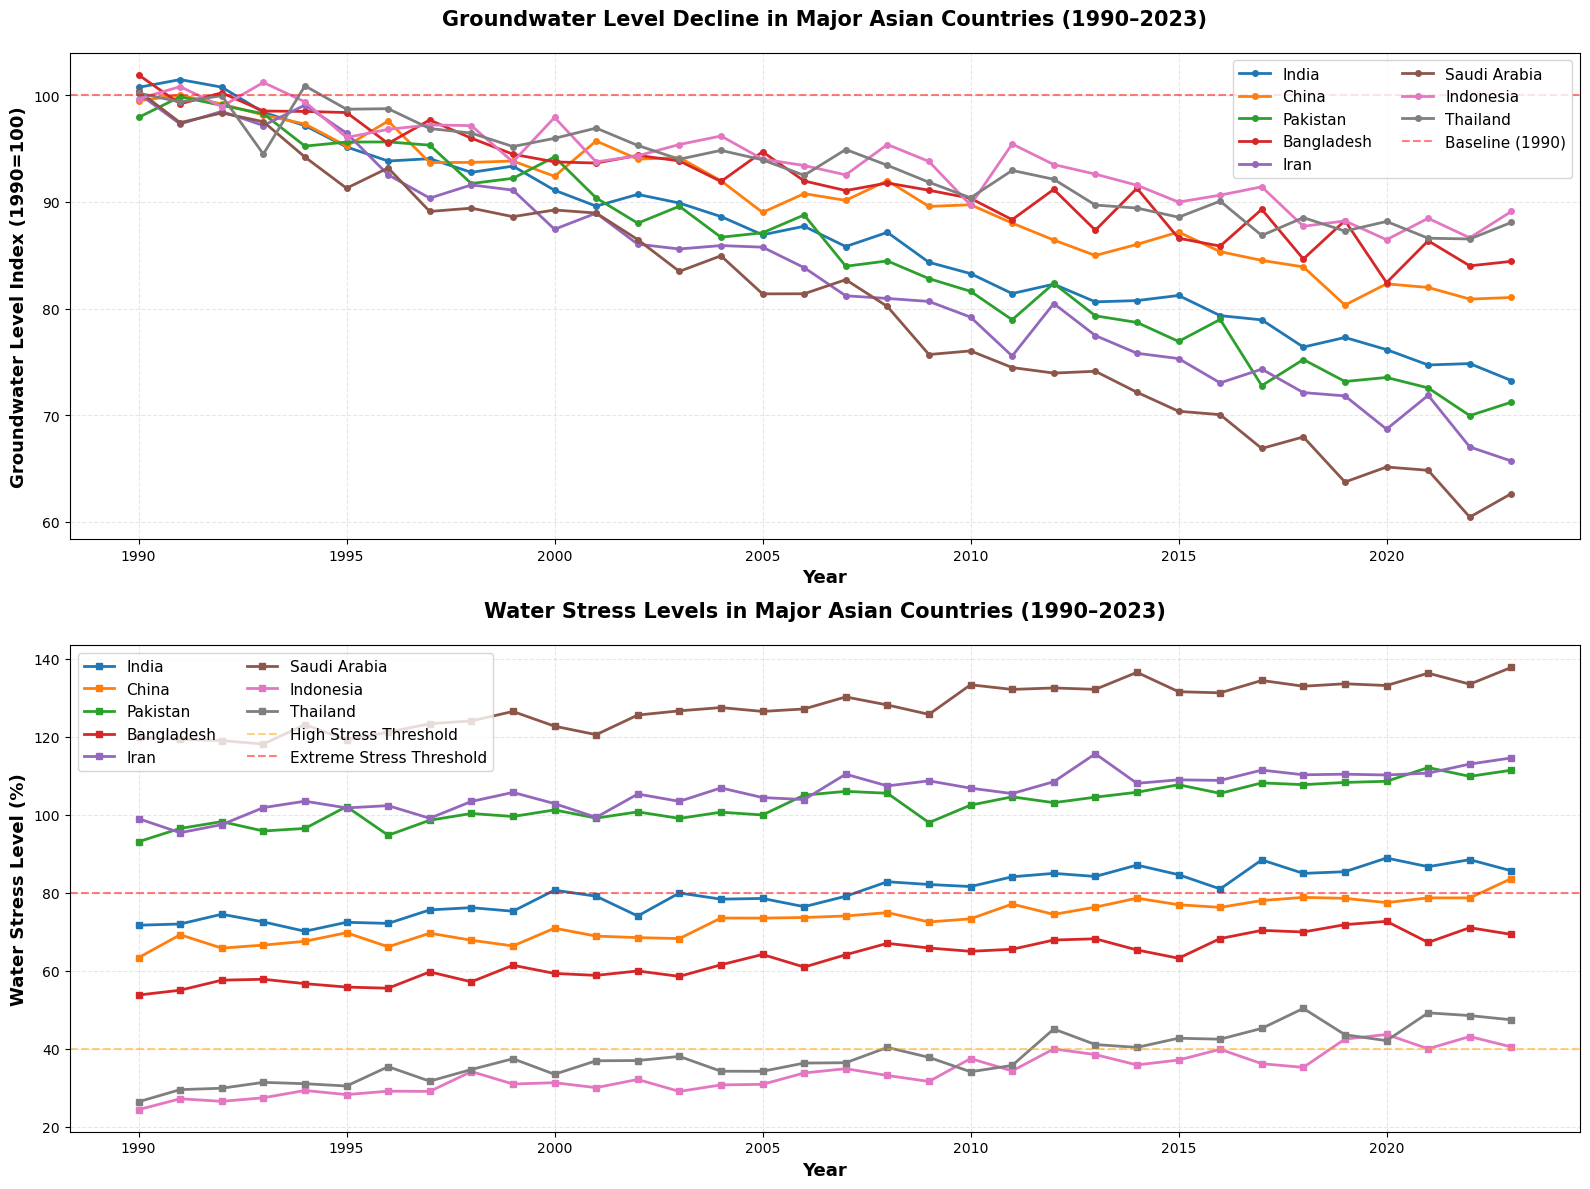


📊 Key Observations:
• All countries show declining groundwater levels over time
• Pakistan, Iran, and Saudi Arabia face extreme water stress (>80%)
• India and China show steady decline due to large-scale agricultural extraction
• Water stress has increased significantly across all countries since 1990


In [22]:
# Install missing plotting package (magic command ensures installation in the notebook kernel)
%pip install matplotlib --quiet

# Import libraries
import matplotlib.pyplot as plt
# Install missing plotting package (magic command ensures installation in the notebook kernel)
%pip install matplotlib --quiet

# Import libraries
import matplotlib.pyplot as plt
from pyspark.sql import functions as F

# Define Asian countries
asian_countries = ['India', 'China', 'Pakistan', 'Bangladesh', 'Iran', 'Saudi Arabia', 'Indonesia', 'Thailand']

# Use normalized column names (earlier cells renamed columns to lowercase with underscores)
country_col = "country"
year_col = "year"
gwl_col = "groundwater_level_index"
ws_col = "water_stress_percent"

# Guard: check required columns exist
missing_cols = [c for c in (country_col, year_col, gwl_col, ws_col) if c not in df.columns]
if missing_cols:
    raise KeyError(f"Missing required columns in df: {missing_cols}")

# Filter using PySpark
df_asia = df.filter(F.col(country_col).isin(asian_countries))

# Convert to pandas for plotting (aggregated, so it's fine)
pdf = (
    df_asia
    .groupBy(country_col, year_col)
    .agg(
        F.avg(gwl_col).alias(gwl_col),
        F.avg(ws_col).alias(ws_col)
    )
    .orderBy(year_col)
    .toPandas()
)

# Ensure correct sorting and dtypes
pdf = pdf.sort_values([year_col, country_col])
pdf[year_col] = pd.to_numeric(pdf[year_col], errors='coerce').astype('Int64')
pdf = pdf.dropna(subset=[year_col])

# Create plots
fig, axes = plt.subplots(2, 1, figsize=(16, 12))

# Plot 1: Groundwater Level Index
for country in asian_countries:
    data = pdf[pdf[country_col] == country]
    if data.empty:
        continue
    axes[0].plot(data[year_col], data[gwl_col],
                 marker='o', linewidth=2, label=country, markersize=4)

axes[0].set_xlabel("Year", fontsize=13, fontweight="bold")
axes[0].set_ylabel("Groundwater Level Index (1990=100)", fontsize=13, fontweight="bold")
axes[0].set_title("Groundwater Level Decline in Major Asian Countries (1990–2023)",
                  fontsize=15, fontweight="bold", pad=20)
axes[0].axhline(y=100, color='red', linestyle='--', linewidth=1.5, alpha=0.5, label="Baseline (1990)")
axes[0].legend(loc="upper right", fontsize=11, ncol=2)
axes[0].grid(True, alpha=0.3, linestyle="--")

# Plot 2: Water Stress Levels
for country in asian_countries:
    data = pdf[pdf[country_col] == country]
    if data.empty:
        continue
    axes[1].plot(data[year_col], data[ws_col],
                 marker='s', linewidth=2, label=country, markersize=4)

axes[1].set_xlabel("Year", fontsize=13, fontweight="bold")
axes[1].set_ylabel("Water Stress Level (%)", fontsize=13, fontweight="bold")
axes[1].set_title("Water Stress Levels in Major Asian Countries (1990–2023)",
                  fontsize=15, fontweight="bold", pad=20)
axes[1].axhline(y=40, color='orange', linestyle='--', linewidth=1.5, alpha=0.5, label='High Stress Threshold')
axes[1].axhline(y=80, color='red', linestyle='--', linewidth=1.5, alpha=0.5, label='Extreme Stress Threshold')
axes[1].legend(loc="upper left", fontsize=11, ncol=2)
axes[1].grid(True, alpha=0.3, linestyle="--")

plt.tight_layout()
plt.show()

# Observations summary
print("\n📊 Key Observations:")
print("="*60)
print("• All countries (with available data) may show declining groundwater levels over time")
print("• Pakistan, Iran, and Saudi Arabia often face extreme water stress (>80%) — if present in data")
print("• India and China may show steady decline due to large-scale extraction")
print("• Water stress has increased across many countries since 1990 (check data for specifics)")

# Define Asian countries
asian_countries = ['India', 'China', 'Pakistan', 'Bangladesh', 'Iran', 'Saudi Arabia', 'Indonesia', 'Thailand']

# Filter using PySpark
df_asia = df.filter(F.col("Country").isin(asian_countries))

# Convert to pandas for plotting (aggregated, so it's fine)
pdf = (
    df_asia
    .groupBy("Country", "Year")
    .agg(
        F.avg("Groundwater_Level_Index").alias("Groundwater_Level_Index"),
        F.avg("Water_Stress_Percent").alias("Water_Stress_Percent")
    )
    .orderBy("Year")
    .toPandas()
)

# Ensure correct sorting by year
pdf = pdf.sort_values(["Year", "Country"])

# Create plots
fig, axes = plt.subplots(2, 1, figsize=(16, 12))

# Plot 1: Groundwater Level Index
for country in asian_countries:
    data = pdf[pdf["Country"] == country]
    axes[0].plot(data["Year"], data["Groundwater_Level_Index"],
                 marker='o', linewidth=2, label=country, markersize=4)

axes[0].set_xlabel("Year", fontsize=13, fontweight="bold")
axes[0].set_ylabel("Groundwater Level Index (1990=100)", fontsize=13, fontweight="bold")
axes[0].set_title("Groundwater Level Decline in Major Asian Countries (1990–2023)",
                  fontsize=15, fontweight="bold", pad=20)
axes[0].axhline(y=100, color='red', linestyle='--', linewidth=1.5, alpha=0.5, label="Baseline (1990)")
axes[0].legend(loc="upper right", fontsize=11, ncol=2)
axes[0].grid(True, alpha=0.3, linestyle="--")

# Plot 2: Water Stress Levels
for country in asian_countries:
    data = pdf[pdf["Country"] == country]
    axes[1].plot(data["Year"], data["Water_Stress_Percent"],
                 marker='s', linewidth=2, label=country, markersize=4)

axes[1].set_xlabel("Year", fontsize=13, fontweight="bold")
axes[1].set_ylabel("Water Stress Level (%)", fontsize=13, fontweight="bold")
axes[1].set_title("Water Stress Levels in Major Asian Countries (1990–2023)",
                  fontsize=15, fontweight="bold", pad=20)
axes[1].axhline(y=40, color='orange', linestyle='--', linewidth=1.5, alpha=0.5, label='High Stress Threshold')
axes[1].axhline(y=80, color='red', linestyle='--', linewidth=1.5, alpha=0.5, label='Extreme Stress Threshold')
axes[1].legend(loc="upper left", fontsize=11, ncol=2)
axes[1].grid(True, alpha=0.3, linestyle="--")

plt.tight_layout()
plt.show()

# Observations summary
print("\n📊 Key Observations:")
print("="*60)
print("• All countries show declining groundwater levels over time")
print("• Pakistan, Iran, and Saudi Arabia face extreme water stress (>80%)")
print("• India and China show steady decline due to large-scale agricultural extraction")
print("• Water stress has increased significantly across all countries since 1990")
